In [ ]:
import numpy
import numpy as np
import pandas as pd 
from sympy import *
from matplotlib import pyplot as plt
import seaborn as sns
import plotly as px
import h5py
import math

from collections import OrderedDict
from decimal import Decimal
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

import peakutils
import pywt
# import pyecg
# import systole
# from systole.detection import ecg_peaks

# from ecgdetectors import Detectors

import neurokit2 as nk
# from statsmodels.tsa.seasonal import STL

import scipy
import scipy.signal as signal
from scipy.stats import weibull_max
from scipy import interpolate
# from pyecg import ECGRecord
# import WTdelineator

In [ ]:
!pip install peakutils

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install neurokit2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.2 MB 17.2 MB/s 


In [ ]:
plt.rcParams['font.size'] = 18
plt.rcParams.update({'font.size': 18})

In [ ]:
sns.set_style('whitegrid')
pd.set_option('display.max_columns', 100)

In [ ]:
#sample_rate - 400
file = h5py.File('/content/drive/MyDrive/Дипломная работа/ecg_tracings.hdf5', 'r')
# file = h5py.File('ecg_tracings.hdf5', 'r')

file.keys()
data = file.get('tracings')

def take_ecg_sample(person_idx, zone='II', show=False):
    """
    idx:  индекс записи экг
    zone: отведение
    show: график
    ->    значения записи экг
    """
    
    ecg_data = pd.DataFrame(data=data[person_idx])
    ecg_data = ecg_data.rename(columns={0:'I', 1:'II', 2:'III', 3:'v1', 4:'v2', 5:'v3', 6:'v4', 7:'v5', 8:'v6', 9:'aVR', 10:'aVL', 11:'aVF'})
    ecg_sample = ecg_data[zone].values
    
    if show:
        plt.figure(figsize=(18, 8))
        # fig, ax = plt.subplots()

        # plt.plot(ecg_data['v2'])
        sns.lineplot(data=ecg_data['II'], color='black')
        plt.title('II')
    
    return ecg_sample

In [ ]:
def take_ecg_sample_xldb(person_idx, zone='II', sr=500, show=False):
    
    '''
    zone (lead-отведение):  ['I', 'II', 'III', 'AVR', 'AVL', 'AVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']
    sr (sample rate): 100Hz, 500Hz
    '''
    
    path = 'ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1/records500/'
    
    if sr == 100:
        path = 'ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1/records100/'
    
    if person_idx > 21837 or person_idx < 1:
        raise ValueError('Wrong index, 21837-last')
    
    len_pidx = abs(len(str(person_idx)) - 5)
    if len_pidx !=  0:
        str_idx = '0' * len_pidx
        str_idx += str(person_idx)
    else:
        str_idx = str(person_idx)
    
    

    str_fold = str_idx[:2] + "000"
    
    
    path += str_fold + '/' + str_idx
    
    if sr == 100:
        hea_path = path + '_lr.hea'
    else:
        hea_path = path + '_hr.hea'
    
    record = ECGRecord.from_wfdb(hea_path)


    time = record.time
    signal = numpy.array(record.get_lead(zone))
    
    if show:
        signal_plot(signal)
    return signal

In [ ]:
xldf = pd.read_csv('ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1/ptbxl_database.csv', index_col='ecg_id')

FileNotFoundError: ignored

In [ ]:
def signal_plot(ecg_sample, fsize=(18, 8)):
    fig, ax  = plt.subplots(figsize=(15,8))
    ax.set_xlabel('time [n] - отсчёты')
    ax.set_ylabel('mV')
#     plt.figure(figsize=fsize, )
    plt.plot(ecg_sample)

# Моделирование сигнала

In [ ]:
def r_peak_detection(ecg_sample, max_th, min_dist, show=False):
    """
    ecg_sample: запись экг
    max_th:     амплитудный порог
    min_dist:   минимальная дистанция RR'
    ->          индексы R-пиков 
    """

    # амплитудно-пороговый метод нахождения r-пика
    peak_indicies = peakutils.indexes(ecg_sample, thres=max_th, min_dist=min_dist)
    
    if show:
        fig, ax  = plt.subplots(figsize=(15,8))
        ax.set_title('R-peaks')
        ax.set_xlabel('time [n] - отсчёты')
        ax.set_ylabel('Δφ, mV')
        ax.plot(ecg_sample)
        for peak in peak_indicies:
        #   Отображение временных меток (Детекция R-пиков)
            ax.axvline(x=peak, color="r")
            
    return peak_indicies

In [ ]:
def waves_detection(ecg_sample, sr, method='dwt', show=False):
    """
    :ecg_sample: запись экг
    :method:     метод обнаружения волн ['dwt', 'cwt', 'peak']
    //on_off:     включение начала/конца волны (onset, offset, all)
    //marker:     маркер волны
    :sr:         sample rate - частота дискретизации
    
    //peaks:      ['all', 'main', 'onset', 'offset']
    
    :return:     _, waves_peak, waves_df, waves_df_rel, mean_pqrst_amp
    ->           словарь индексов pqrst-волн, маркированный график сигнала,
                 словарь относительных точек внутри PPi    
    """
    rpeaks = r_peak_detection(ecg_sample, max_th=.7, min_dist=100)
    # компенсация шумовых помех     
    ecg_sample_clean = nk.ecg_clean(ecg_sample, sampling_rate=sr)
    
    _, waves_peak = nk.ecg_delineate(ecg_sample, rpeaks, sampling_rate=sr, method="dwt", show_type='peaks')
    
    #-------------------------------------------------------------------------------------------------------
    # Создадим датасет, куда будут входить сами точки их коэф-ты положения внутри PP
    waves_df = pd.DataFrame(data=waves_peak)
    
    # Добавим R-пики     
    waves_df['r_peaks'] = r_peak_detection(ecg_sample, max_th=.7, min_dist=100, show=True)
    
    # Считаем длительности PP в отсчётах     
    pon_diff = np.diff(waves_df['ECG_P_Onsets'])
    p_on_diff = np.concatenate((np.array(pon_diff), np.array([pon_diff[-1]])), axis=0)
    
    # Добавляем в датасет
    waves_df['P_Onsets_diff'] = p_on_diff
    
    #Коэф-ты положения     
    waves_df['p_rel'] = (waves_df['ECG_P_Peaks'] - waves_df['ECG_P_Onsets']) / waves_df['P_Onsets_diff']
    waves_df['p_off_rel'] = (waves_df['ECG_P_Offsets'] - waves_df['ECG_P_Onsets']) / waves_df['P_Onsets_diff']
    waves_df['q_rel'] = (waves_df['ECG_Q_Peaks'] - waves_df['ECG_P_Onsets']) / waves_df['P_Onsets_diff']
    waves_df['r_rel'] = (waves_df['r_peaks'] - waves_df['ECG_P_Onsets']) / waves_df['P_Onsets_diff']
    waves_df['s_rel'] = (waves_df['ECG_S_Peaks'] - waves_df['ECG_P_Onsets']) / waves_df['P_Onsets_diff']
    waves_df['t_on_rel'] = (waves_df['ECG_T_Onsets'] - waves_df['ECG_P_Onsets']) / waves_df['P_Onsets_diff']
    waves_df['t_rel'] = (waves_df['ECG_T_Peaks'] - waves_df['ECG_P_Onsets']) / waves_df['P_Onsets_diff']
    waves_df['t_off_rel'] = (waves_df['ECG_T_Offsets'] - waves_df['ECG_P_Onsets']) / waves_df['P_Onsets_diff']
    
    # доп коэф-ты для точек q' s' n1 n2 n3 n4     
    waves_df['_q_rel'] = (waves_df['p_off_rel'] + waves_df['q_rel']) / 2.2
    waves_df['_s_rel'] = (waves_df['s_rel'] + waves_df['t_on_rel']) / 2.8
    
    
    waves_df['n1'] = waves_df['p_rel'] / 1.6
    waves_df['n2'] = (waves_df['p_rel'] + waves_df['p_off_rel'] ) / 2
    waves_df['n3'] = (waves_df['t_on_rel'] + waves_df['t_rel'] ) / 2 
    waves_df['n4'] = (waves_df['t_off_rel'] + waves_df['t_rel'] ) / 2

    #Уберём лишние значения и переопределим порядок в датасете с относительными значениями
    waves_df.loc[len(waves_df)-1, 'p_rel':] = 0
    
    waves_df_rel = waves_df.loc[:, 'ECG_T_Offsets':'n4'].copy().reindex(
        columns=['n1', 'p_rel', 'n2', 'p_off_rel', '_q_rel', 'q_rel', 'r_rel', 's_rel', '_s_rel',
                               't_on_rel', 'n3', 't_rel', 'n4', 't_off_rel'])
    waves_df_rel['pp_diff'] = p_on_diff
    # ===========================================================================================  
    # Посчитаем среднюю амплитуду волновых точек P Q R S T
#     p_mean_amp = ecg_sample[waves_df[waves_df['ECG_P_Peaks'].notnull()]['ECG_P_Peaks']].mean()
#     q_mean_amp = ecg_sample[waves_df[waves_df['ECG_Q_Peaks'].notnull()]['ECG_Q_Peaks']].mean()
#     r_mean_amp = ecg_sample[waves_df[waves_df['r_peaks'].notnull()]['r_peaks']].mean()
#     s_mean_amp = ecg_sample[waves_df[waves_df['ECG_S_Peaks'].notnull()]['ECG_S_Peaks']].mean()
#     t_mean_amp = ecg_sample[waves_df[waves_df['ECG_T_Peaks'].notnull()]['ECG_T_Peaks']].mean()
    
    # Находим усреднённые характеристики амплитуд pqrst     (upd 1)
    p_mean_amp = np.mean(ecg_sample[ np.array(waves_df[waves_df['ECG_P_Peaks'].notnull()]['ECG_P_Peaks']).astype(int) ])
    q_mean_amp = np.mean(ecg_sample[ np.array(waves_df[waves_df['ECG_Q_Peaks'].notnull()]['ECG_Q_Peaks']).astype(int) ])
    r_mean_amp = np.mean(ecg_sample[ np.array(waves_df[waves_df['r_peaks'].notnull()]['r_peaks']).astype(int) ])
    s_mean_amp = np.mean(ecg_sample[ np.array(waves_df[waves_df['ECG_S_Peaks'].notnull()]['ECG_S_Peaks']).astype(int) ])
    t_mean_amp = np.mean(ecg_sample[ np.array(waves_df[waves_df['ECG_T_Peaks'].notnull()]['ECG_T_Peaks']).astype(int) ])
    
    # список со средними амплитудами для P Q R S T    
    mean_pqrst_amp = np.around([p_mean_amp, q_mean_amp, r_mean_amp, s_mean_amp, t_mean_amp], 3)

    #-------------------------------------------------------------------------------------------------------     
    # выводим график с маркерами волн, из словаря waves_peak    
    if show:
        fig, ax  = plt.subplots(figsize=(15,8))
        ax.set_title('PQST-waves')
        ax.set_xlabel('time [n] - отсчёты')
        ax.set_ylabel('mV')
        ax.plot(ecg_sample)
        
        # Заменим nan на numpy.nan
        for wave in waves_peak.keys():
            for i in range(len(waves_peak['ECG_P_Peaks'])):
                if pd.isna(waves_peak[wave][i]):
                    waves_peak[wave][i] = numpy.nan
        
        
        for i in range(len(waves_peak['ECG_P_Peaks'])):
            
            # значения сигнала в определённых индексах волн
            
            if not pd.isna(waves_peak['ECG_P_Peaks'][i]):
                peak_p_value = ecg_sample[waves_peak['ECG_P_Peaks'][i]]
            else:
                peak_p_value = numpy.nan
            
            if not pd.isna(waves_peak['ECG_P_Onsets'][i]):
                peak_pon_value = ecg_sample[waves_peak['ECG_P_Onsets'][i]]
            else:
                peak_pon_value = numpy.nan
            
            if not pd.isna(waves_peak['ECG_Q_Peaks'][i]):
                peak_q_value = ecg_sample[waves_peak['ECG_Q_Peaks'][i]]
            else:
                peak_q_value = numpy.nan
            
            if not pd.isna(waves_peak['ECG_S_Peaks'][i]):
                peak_s_value = ecg_sample[waves_peak['ECG_S_Peaks'][i]]
            else:
                peak_s_value = numpy.nan
            
            if not pd.isna(waves_peak['ECG_T_Peaks'][i]):
                peak_t_value = ecg_sample[waves_peak['ECG_T_Peaks'][i]]
            else:
                peak_t_value = numpy.nan
            
            # отображение волн точками             
            p = ax.scatter(x=waves_peak['ECG_P_Peaks'][i], y=peak_p_value, color='green', alpha=.5, linewidths=3)
            pon = ax.scatter(x=waves_peak['ECG_P_Onsets'][i], y=peak_pon_value, color='#5df656', alpha=.7, linewidths=3)
            
            q = ax.scatter(x=waves_peak['ECG_Q_Peaks'][i], y=peak_q_value, color='#fc9429', alpha=.7, linewidths=3)
            s = ax.scatter(x=waves_peak['ECG_S_Peaks'][i], y=peak_s_value, color='#fc6b06', alpha=.7, linewidths=3)
            t = ax.scatter(x=waves_peak['ECG_T_Peaks'][i], y=peak_t_value, color='#a87fea', alpha=.7, linewidths=3)
        
        for i in range(len(rpeaks)):
            peak_r_value = ecg_sample[rpeaks[i]]
            ax.scatter(x=rpeaks[i], y=peak_r_value, color='red', alpha=.7, linewidths=5, marker="|")
        
        plt.legend((pon, p, q, s, t),
           ('P_onset', 'P', 'Q', 'S', 'T'),
           scatterpoints=1,
           loc='upper left',
           ncol=2,
           fontsize=12)
    
    return _, waves_peak, waves_df, waves_df_rel, mean_pqrst_amp
#     return _, waves_peak, waves_df, waves_df_rel

## Замер коэф-тов положения особых точек внутри каждого кардиоцикла на исходном сигнале и моделирование по ним.

In [ ]:
def myround(num):
    dec = Decimal(num)
    adj = abs(dec.adjusted())+1
    return round(num, adj)

def round_(number):
    dist = int(math.log10(abs(number))) #number of zeros after decimal point
    return (round(number, abs(dist) + 2) if dist != 0 else round(number))

def weib(x,l,k):
    """
    W(k, λ): - Распределение Вейбулла; k, λ - параметры распределения
    :l: λ - масштаб распределения распределения СВ Вейбулла
    :k: k - параметр формы распределения СВ Вейбулла
    
    Если величину X принять за наработку до отказа, тогда получается распределение, 
        в котором интенсивность отказов пропорциональна времени. Тогда:
        
    k < 1 показывает, что интенсивность отказов уменьшается со временем
    k = 1 показывает, что интенсивность отказов не меняется со временем
    k > 1 показывает, что интенсивность отказов увеличивается со временем
    В материаловедении коэффициент k известен как модуль Вейбулла.
    
    """
    return (k / l) * (x / l)**(k - 1) * np.exp(-(x / l)**k)

In [ ]:
def generate_model_sig_mean(points_row, amp_info=None, adaptive='rel',  show=True, method='spline'):
    
    """
    :pp_len:    (int) ширина PP-интервала 
    //:adaptive:  ['rel', 'all'], all - растягивает по амплитуде
    //waves_df:  датасет, содержащий в себе информацию о волнах <- waves_detection() 
    :method:    ['spline', 'weib'] - моделирование P и T волны сплайнами, либо распр. Вейбулла 
    :return:    pqrst
    ->          [модельный сигнал]    
    
    
    """
#   Общие сведения
# ----------------------------------------------
# ----------------------------------------------
#     # Относительные характеристики положения волн     
#     p_rel, p2_rel, q_rel, r_rel, s_rel, t1_rel, t_rel, t2_rel = (
#     0.08,  0.12,  0.187,  0.22,  0.25,  0.42,   0.49,  0.54
#     )

#     #  Коэф-ты положения опорных точек внутри PP  
#     coef_dict = {
#         #p1 - 1 index         
#         'p1': 1, 'n1': math.ceil(0.04 * pp_len), 'p_rel': math.ceil(p_rel * pp_len), 'n2':math.ceil(0.1 * pp_len),
#         'p2_rel': math.ceil(p2_rel * pp_len),
#         #q'
#         '_q': math.ceil(0.17 * pp_len), 'q_rel': math.ceil(q_rel * pp_len), 'r_rel': math.ceil(r_rel * pp_len),
#         's_rel': math.ceil(s_rel * pp_len),
#         #s'
#         '_s':math.ceil(0.27 * pp_len), 't1_rel': math.ceil(t1_rel * pp_len), 'n3': math.ceil(0.45 * pp_len),
#         't_rel': math.ceil(t_rel * pp_len),    'n4': math.ceil(0.51 * pp_len), 't2_rel': math.ceil(t2_rel * pp_len),
        
#     }
# ------------------------------------------------
    
    
    #n1, n2, n3, n4 - доп.узловые точки
    
    # амплитуды, характерные для волн и доп.узловых точек
    amp_dict_template = {'p1':0, 'n1': 0.14,'p':0.23,'n2':0.1, 'p2':0, '_q':0,'q':-0.23,'r':1.2, 's':-0.37, 's_':0,
        't1':0,'n3':0.26,'t':0.39, 'n4':0.21,'t2':0
        
    }
    
    amp_dict = {'p1':0, 'n1': amp_info[0] / 1.642, 'p':amp_info[0],'n2':amp_info[0] / 2.3, 'p2':0, '_q':0,'q':amp_info[1],
                'r':amp_info[2], 's':amp_info[3], 's_':0, 't1':0,'n3':amp_info[4] / 1.5,
                't':amp_info[4], 'n4':amp_info[4] / 1.857,'t2':0

    }

    

# ------------------------------------------------
    # Длина PP-интервала     
    pp_len = int(points_row[-1])
    
    # Преобразуем в словарь    
    points_dict = dict(points_row[:-1])
    
    arr = list(map(myround, list(points_dict.values())))
    np_arr = np.array(arr)
   
    # преобразуем индексы волн и амплитуды к списку
    p1_ind = [1]
    wave_ind = np.concatenate( (p1_ind, list(np.ceil(np_arr * pp_len).astype(int))),  axis=0)
    
    for i in range(1, len(wave_ind)):
        if wave_ind[i] == wave_ind[i-1]:
            wave_ind[i] += 1
        
    
    amp_list = list(amp_dict.values())
    
    
# -------------------------------------------------------------------------------------- 
    # x - значения временных отсчётов
    x = numpy.arange(0, pp_len, 1)
    
    # y - значение сигнала 
    y = numpy.zeros(pp_len)
    
    # Присваиваем значения амплитуды по индексам волн     
    y[wave_ind] = amp_list
    
    #декомпозириуем сигнал по сегментам
    #------------------------------------------------------------------------------------ 
    # P-волна     
    # мин число узлов для кубической интерполяции - 4
    
    
    # индексы p-волны (p1 n1 p n2 p2) 
    p_wave_ind = [wave_ind[0], wave_ind[1], wave_ind[2], wave_ind[3], wave_ind[4]]
    p_wave_vals =y[[wave_ind[0], wave_ind[1], wave_ind[2], wave_ind[3], wave_ind[4]]]
    p_wave_len = len(y[:wave_ind[4]+1])
    
    if method == 'spline':
        # интерполирующая сплайн-функция, макс.степень сплайна = 3 (kind=3) 
        # upd: понизил до 2х для избежания дефекта
        f_p = interpolate.interp1d(p_wave_ind, p_wave_vals, kind=2)

        # временные отсчёты для p-волны
        x_p = numpy.arange(1, wave_ind[4]+1, 1)
        # Смоделированный фрагмент для P-волны 
        y_p = f_p(x_p)
#         if p_wave_vals[0] < 0:
#             y_p += (p_wave_vals[0] * -1)
    
    #weib     
    else:
        x_scale = 7.5 # масштабирование ряда распределения
        x_p = numpy.arange(1, wave_ind[4]+1, 1) / (wave_ind[4]+1 / x_scale)
        y_p = weib(x_p, 0.65, 4.8)
        max_y_p = max(y_p)
        # коэф-т растяжения         
        c_p = amp_info[0] / max_y_p        
        y_p *= c_p
#         if p_wave_vals[0] < 0:
#             y_p += (p_wave_vals[0] * -1)
        
    
    #------------------------------------------------------------------------------------     
    # P2Q' - сегмент, нулевые значения (фрагмент изолинии)     
    y_p2_q = y[wave_ind[4]:wave_ind[5]]
    p2_q_len = len(y[wave_ind[4]:wave_ind[5]])
    #------------------------------------------------------------------------------------ 
    
    # QRS-комплекс (Q'QRSS')
    qrs_wave_ind = [wave_ind[5], wave_ind[6], wave_ind[7], wave_ind[8],wave_ind[9]]
    qrs_wave_vals = y[[wave_ind[5], wave_ind[6], wave_ind[7], wave_ind[8],wave_ind[9]]]
    qrs_wave_len = len(y[wave_ind[5]:wave_ind[9]+1])
    
    # интерполирующая линейная функция (kind=1)
    f_qrs = interpolate.interp1d(qrs_wave_ind, qrs_wave_vals, kind=1)
    x_qrs = numpy.arange(wave_ind[5], wave_ind[9]+1, 1)
    y_qrs = f_qrs(x_qrs)
    
    #------------------------------------------------------------------------------------
    # ST - сегмент (S'T1), нулевые значения (фрагмент изолинии) 
    y_s__t1 = y[wave_ind[9]:wave_ind[10]]
    #------------------------------------------------------------------------------------
    
    # T-волна (T1_n3_T_n4_T2)
    t_wave_ind = [wave_ind[10], wave_ind[11], wave_ind[12], wave_ind[13], wave_ind[14]]
    t_wave_vals = y[[wave_ind[10], wave_ind[11], wave_ind[12], wave_ind[13], wave_ind[14]]]
    t_wave_len = len(y[wave_ind[10]:wave_ind[14]+1])
    
    if method == 'spline':
        f_t = interpolate.interp1d(t_wave_ind, t_wave_vals, kind=3)
        x_t = numpy.arange(wave_ind[10], wave_ind[14]+1, 1)
        y_t = f_t(x_t)
    
    #weib     (upd3)
    else:
        x_t = numpy.arange(wave_ind[10], wave_ind[14]+1, 1) - wave_ind[10]
        x_t += 1
        x_t = x_t / (wave_ind[14]+1 / x_scale)
        y_t = weib(x_t, 0.15, 4.8)

        max_y_t = max(y_t)
        # коэф-т растяжения         
        c_t = amp_info[4] / max_y_t        
        y_t *= c_t
    
    #------------------------------------------------------------------------------------
    # T2P1 - конец кардиоцикла     
    y_t_end = y[wave_ind[14]:-2]
    
    
    # Смоделированный кардиоцикл по 15-ти особым точкам (Идеальный сигнал)
    pqrst = numpy.concatenate((y_p, y_p2_q, y_qrs, y_s__t1, y_t, y_t_end), axis=0)
    
    # Вывод графика
    if show:
        fig, ax  = plt.subplots(figsize=(15,8))
        ax.set_title('PQST-waves')
        p1 = ax.scatter(x=wave_ind[0], y=y[wave_ind[0]])
        n1 = ax.scatter(x=wave_ind[1], y=y[wave_ind[1]], color='black')
        p = ax.scatter(x=wave_ind[2], y=y[wave_ind[2]])
        n2 = ax.scatter(x=wave_ind[3], y=y[wave_ind[3]], color='black')
        p2 = ax.scatter(x=wave_ind[4], y=y[wave_ind[4]])
        _q = ax.scatter(x=wave_ind[5], y=y[wave_ind[5]])
        q = ax.scatter(x=wave_ind[6], y=y[wave_ind[6]])
        r = ax.scatter(x=wave_ind[7], y=y[wave_ind[7]])
        s = ax.scatter(x=wave_ind[8], y=y[wave_ind[8]])
        s_ = ax.scatter(x=wave_ind[9], y=y[wave_ind[9]])
        t1 = ax.scatter(x=wave_ind[10], y=y[wave_ind[10]])
        n3 = ax.scatter(x=wave_ind[11], y=y[wave_ind[11]], color='black')
        t = ax.scatter(x=wave_ind[12], y=y[wave_ind[12]])
        n4 = ax.scatter(x=wave_ind[13], y=y[wave_ind[13]], color='black')
        t2 = ax.scatter(x=wave_ind[14], y=y[wave_ind[14]])
        
        plt.legend((p1, n1, p, n2, p2, _q, q, r, s, s_, t1, n3, t, n4, t2),
           ('P1', 'n1', 'P', 'n2', 'P2', "Q'", 'Q', 'R', 'S', "S'",  'T1', 'n3', 'T', 'n4','T2'),
           scatterpoints=1,
           loc='upper left',
           ncol=2,
           fontsize=12)
        
        plt.plot(y)
    
#   ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++  
#     return  wave_ind, amp_list, pp_len, pqrst
    return pqrst

In [ ]:
def del_zspan(ecg_sample):
    del_fence = None
    for i in range(len(ecg_sample)-1, len(ecg_sample) // 2, -1):
        if ecg_sample[i] != 0:
            del_fence = i
            break
    return ecg_sample[: del_fence]

In [ ]:
def overlay_signals(ecg_sample, show=True, bias=0, amp_mode=False, method='spline'):
    """
    :ecg_sample: сигнал ЭКС
    :show:       график наложения
    :bias:       сдвиг сигнала по оси y
    //:amp_mode:   
    :method:     ['spline', 'weib'] - представление модельного сигнала (сплайнами / распределением Вейбулла)
    :return:     ideal_ecg_full, ecg_sample_cut
    ->           [исходный сигал, смоделированный сигнал (равные по длине)]
                        Сигналы накладываются с перовй точки начала P-волны у исходного ecg_sample 
                
    """
    
    clean_ecg_sample = del_zspan(ecg_sample)

    
    
    # детекция волновых точек     

    _, waves_peak, waves_df, waves_rel, mean_pqrst_amp = waves_detection(ecg_sample, show=True, sr=400)
    
    if pd.isna(waves_df.iloc[0]['P_Onsets_diff']):
        waves_rel_copy = waves_rel.iloc[1:].copy()
    #upd     
    else:
        waves_rel_copy = waves_rel.iloc[:].copy()
    
    # индексы начала p-волны  (???)   
    p_onset_ind = list(waves_peak['ECG_P_Onsets'])
    
    #    # Удаление nan  
    for i in range(len(p_onset_ind)-1):
        if pd.isna(p_onset_ind[i]):
            del p_onset_ind[i]

            

    pp_diff = waves_rel_copy['pp_diff']
#     ---------------------------------------------------------------
    # смоделированнные кардиоциклы 
    pp_yi = []
    
    for i in range(len(pp_diff)-1):
        p_row = waves_rel_copy.iloc[i]
#         upd2
        pqrst = generate_model_sig_mean(p_row, amp_info=mean_pqrst_amp, method=method)
#         pqrst = generate_weib(p_row, amp_info=mean_pqrst_amp)
        pp_yi.append(list(pqrst))

    pp_points = tuple(pp_yi)
    
    # Конкатенация кардиоциклов в смоделированном сигнале

    # Смоделированный идеальный сигнал на основе исходного
    ideal_ecg_full = numpy.concatenate(pp_points, axis=0)
   
    # end - значение для уравнивания по длине
    end = int(len(ideal_ecg_full) - len(clean_ecg_sample[p_onset_ind[0]:]))
    ecg_len = len(clean_ecg_sample[p_onset_ind[0]:])
    ecg_sample_cut = clean_ecg_sample[p_onset_ind[0]:end]
    
    if show:
        fig, ax  = plt.subplots(figsize=(15,8))
#         plt.figure(figsize=(18,8))
        ax.set_xlabel('time [n] - отсчёты')
        ax.set_ylabel('mV')
        plt.plot(ecg_sample_cut)
        plt.plot(ideal_ecg_full+bias, '--', color='red')
        
    mse = mean_squared_error(ideal_ecg_full+bias, ecg_sample_cut)
    mae = mean_absolute_error(ideal_ecg_full+bias, ecg_sample_cut)
    print('mse: {:.3f}'.format(mse))
    print('mae: {:.3f}'.format(mae))
    
#     return ecg_sample_cut, ideal_ecg_full
#     return  pp_yi, ideal_ecg_full, ecg_sample_cut
    return ideal_ecg_full, ecg_sample_cut 
#     return p_onset_ind

In [ ]:
def r_peak_detect2(ecg_sample, sr, show=False):
    
    """
    ecg_sample: запись экг
    sr:         частота дискретизации
    ->          индексы R-пиков 
    """
    
    # очистка от шумовых помех     
    clean_ecg_sample = nk.ecg_clean(ecg_sample, sampling_rate=sr)
    
    # обнаружение r-пиков библиотекой neurokit     
    peak_indicies = nk.ecg_peaks(clean_ecg_sample, sampling_rate=sr)[1]['ECG_R_Peaks']
    
    if show:
        fig, ax  = plt.subplots(figsize=(15,8))
        ax.set_title('R-peaks')
        ax.set_xlabel('time [n] - отсчёты')
        ax.set_ylabel('mV')
        ax.plot(ecg_sample)
        for peak in peak_indicies:
        #   Отображение временных меток (Детекция R-пиков)
            ax.axvline(x=peak, color="r")

    return peak_indicies   

In [ ]:
def FFA(data,dis):
    iSampleRate = dis # Частота дискретизации, 1000 отсчетов в секунду
    x = data
    iSampleCount = x.shape[0] # Номер образца
    t = np.linspace(0,iSampleCount/iSampleRate,iSampleCount)
    xFFT = np.abs(np.fft.rfft(x)/iSampleCount) # Быстрое преобразование Фурье
    xFFTq=[]
    for i in xFFT:
        xFFTq.append(math.sqrt(i))
        xFreqs = np.linspace(0, iSampleRate/2, int(iSampleCount/2)+1).tolist()
    return xFreqs[5:20], xFFTq[5:20]

def locMax(df):
    maxi=[]
    for i in range(1,len(df)-1):
        if df[i] > df[i-1]:
            if df[i] > df[i+1]:
                maxi.append([df[i],0.5+i/10.0])
    return maxi

def getBaseFrequency(xFFTq):
    max=[-9999999,-1]
    for peak,aX in locMax(xFFTq):
        if max[0]<peak:
            max=[peak,aX]
    return max[1]

def removeSignalDrift(df,sampling_rate):
    xFreqs, xFFTq=FFA(df,sampling_rate)
    basePeriod = (int)(getBaseFrequency(xFFTq)**(-1)*sampling_rate)
    stlTrendSignal = STL(df,period=basePeriod).fit().trend
    return df-stlTrendSignal

def removeHighFreq(x,w=3):
    avg=[]
    it=0
    while it+w<len(x):
        avg.append(x[it:it+w].sum()/w)
        it+=1
    return avg

In [ ]:
def getSpline(clearSignal,s=0.5):
    sig_series = pd.Series(clearSignal)
    x = scipy.interpolate.UnivariateSpline(list(sig_series.index),clearSignal,s=s)
    spline=x(sig_series.index)
    return spline

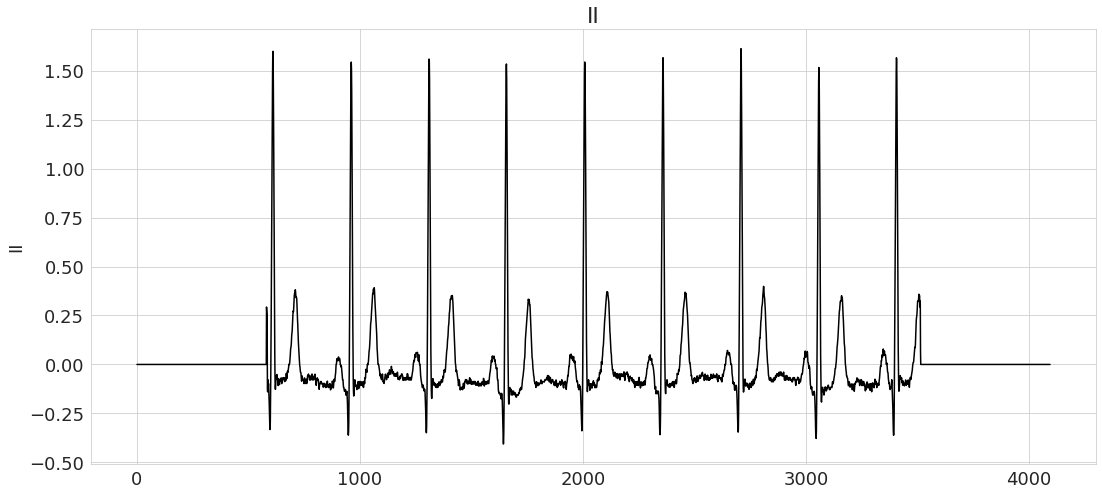

In [ ]:
sig72 = take_ecg_sample(72, show=True)

array([ 610,  961, 1310, 1657, 2008, 2359, 2709, 3058, 3406])

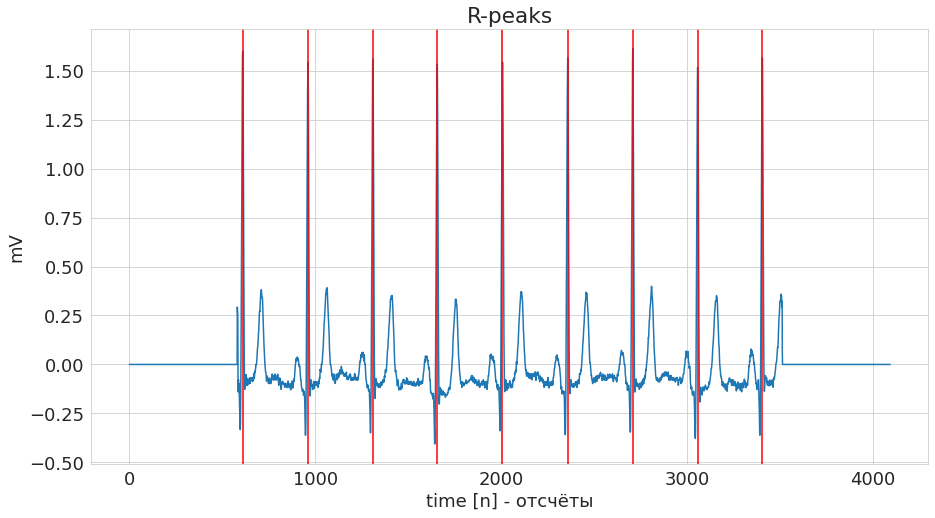

In [ ]:
r_peak_detection(sig72, min_dist=100, max_th=.7, show=True)

(      ECG_P_Peaks  ECG_P_Onsets  ECG_P_Offsets  ECG_Q_Peaks  ECG_R_Onsets  \
 0               0             0              0            0             0   
 1               0             0              0            0             0   
 2               0             0              0            0             0   
 3               0             0              0            0             0   
 4               0             0              0            0             0   
 ...           ...           ...            ...          ...           ...   
 4091            0             0              0            0             0   
 4092            0             0              0            0             0   
 4093            0             0              0            0             0   
 4094            0             0              0            0             0   
 4095            0             0              0            0             0   
 
       ECG_R_Offsets  ECG_S_Peaks  ECG_T_Peaks  ECG_T_Onsets  

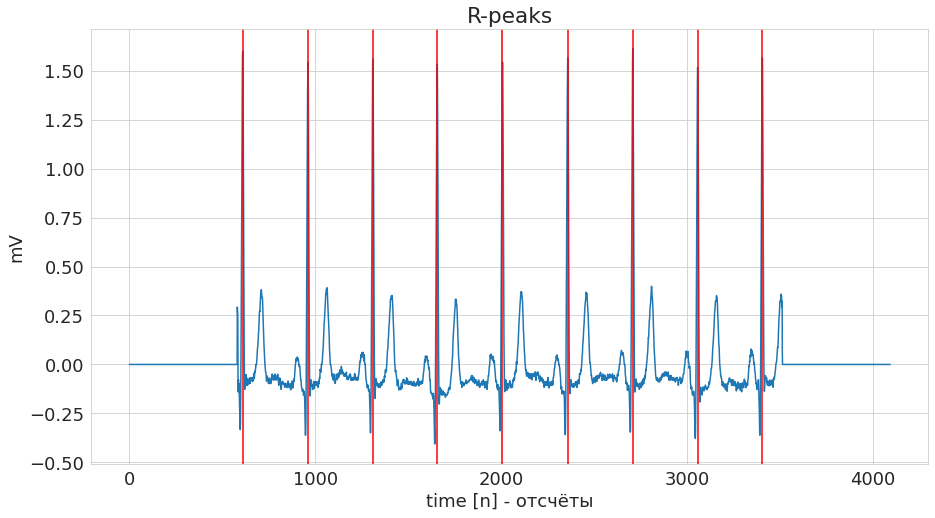

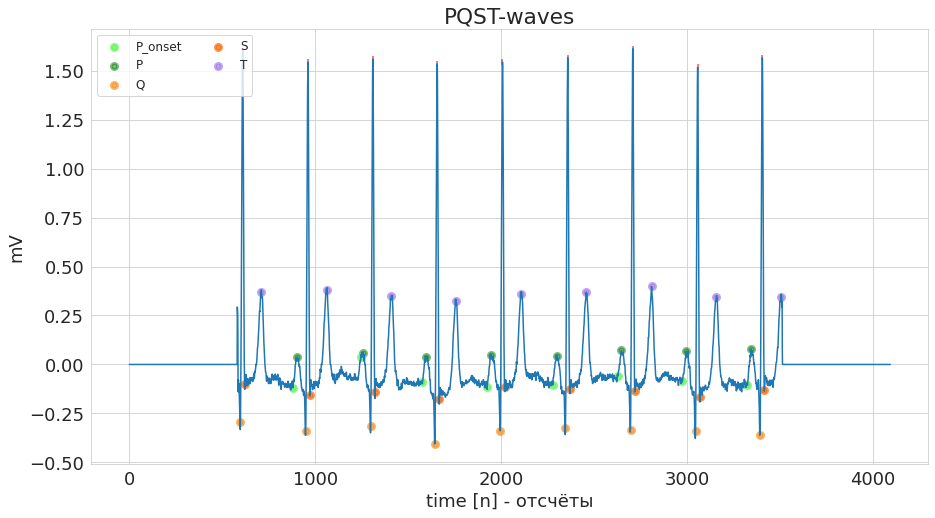

In [ ]:
waves_detection(sig72, sr=400, show=True)

(      ECG_P_Peaks  ECG_P_Onsets  ECG_P_Offsets  ECG_Q_Peaks  ECG_R_Onsets  \
 0               0             0              0            0             0   
 1               0             0              0            0             0   
 2               0             0              0            0             0   
 3               0             0              0            0             0   
 4               0             0              0            0             0   
 ...           ...           ...            ...          ...           ...   
 4091            0             0              0            0             0   
 4092            0             0              0            0             0   
 4093            0             0              0            0             0   
 4094            0             0              0            0             0   
 4095            0             0              0            0             0   
 
       ECG_R_Offsets  ECG_S_Peaks  ECG_T_Peaks  ECG_T_Onsets  

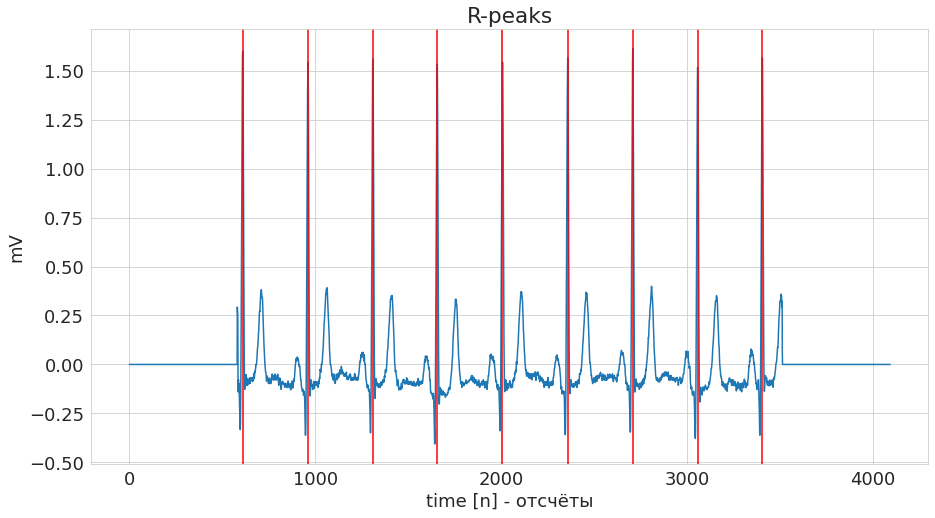

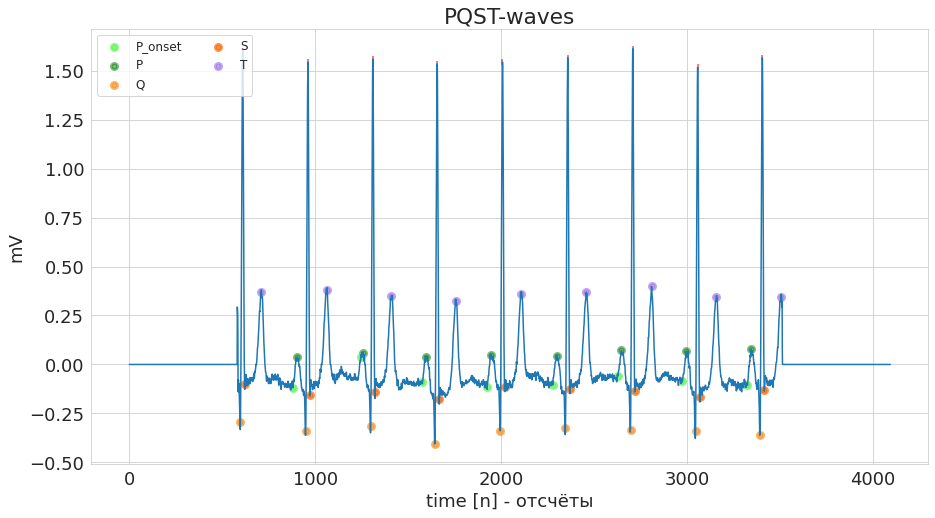

In [ ]:
waves_detection(sig72, sr=400, show=True)

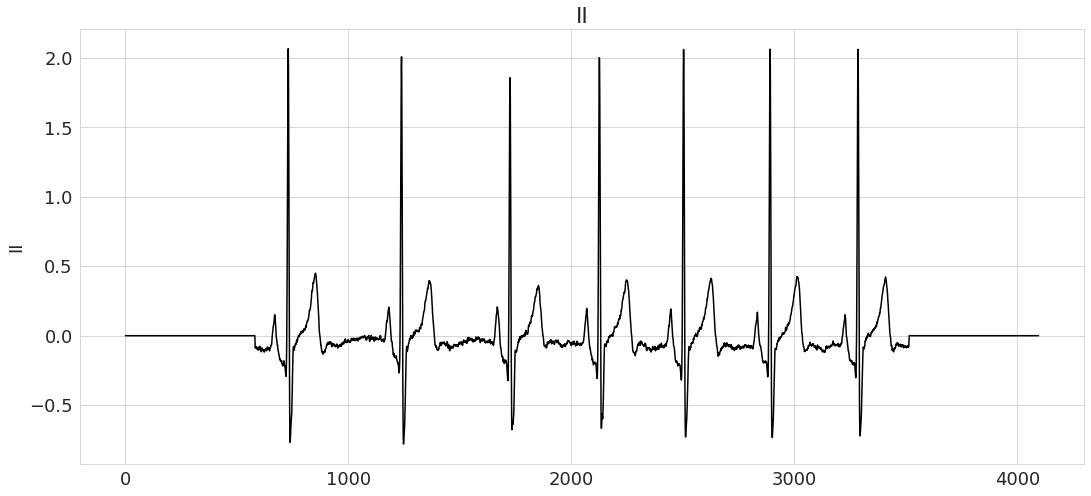

In [ ]:
sig79 = take_ecg_sample(79, show=True)

In [ ]:
sig79_clean = getSpline(sig79)
sig79_clean

array([ 0.00108247,  0.00103686,  0.00099199, ..., -0.00089733,
       -0.00092317, -0.00094929])

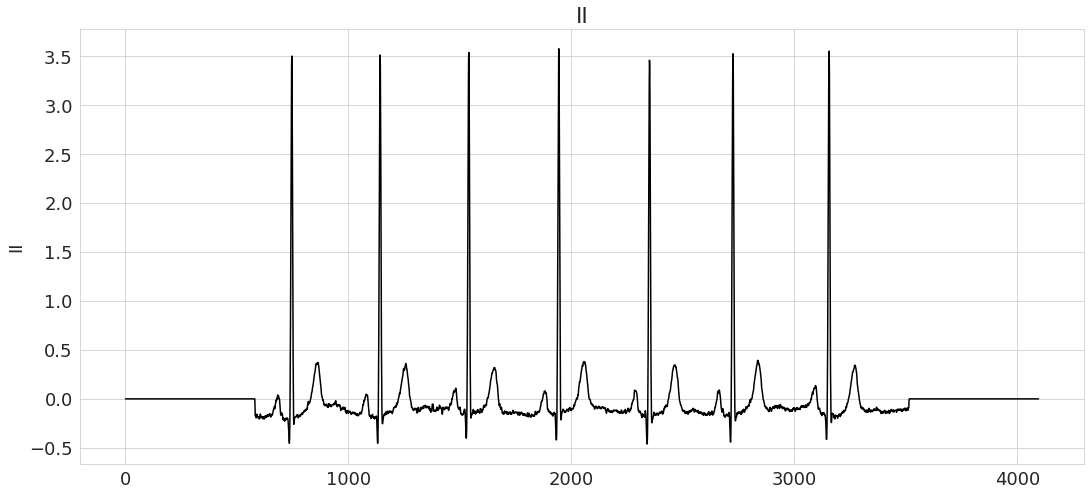

In [ ]:
sig56 = take_ecg_sample(56, show=True)

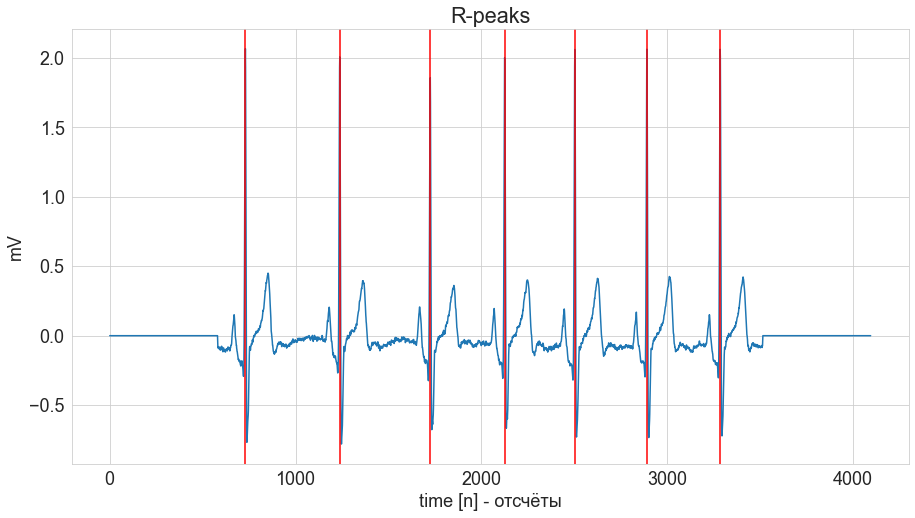

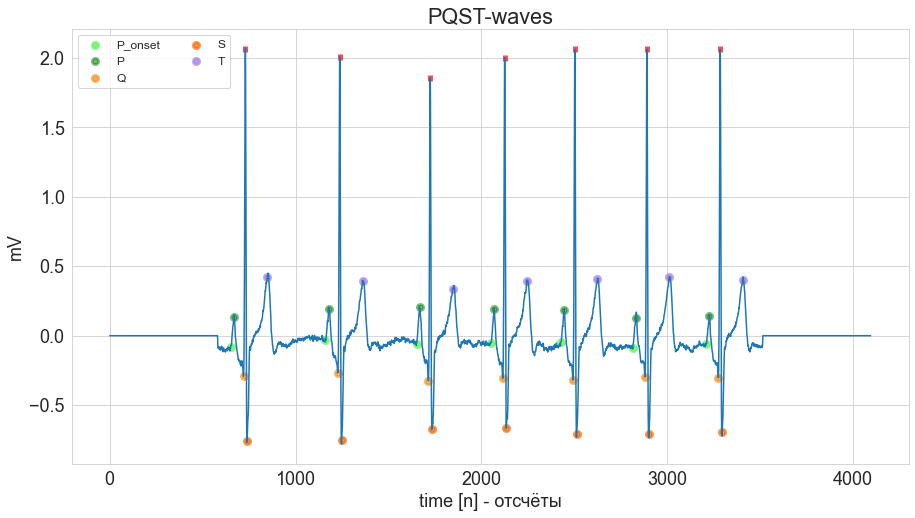

In [ ]:
_, waves_peak, waves_df, waves_df_rel, mean_pqrst_amp = waves_detection(sig79, sr=400, show=True)

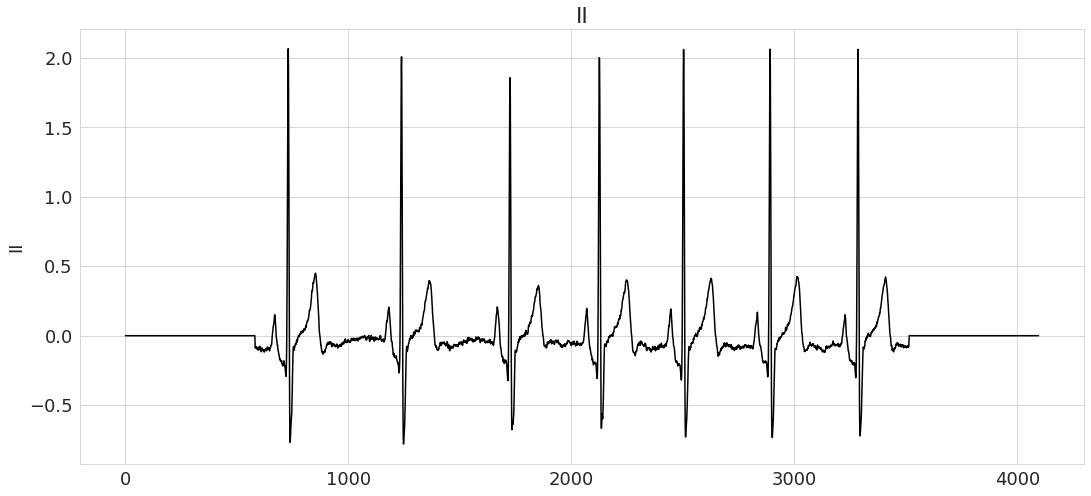

In [ ]:
sig79 = take_ecg_sample(79, show=True)

mse: 0.016
mae: 0.066


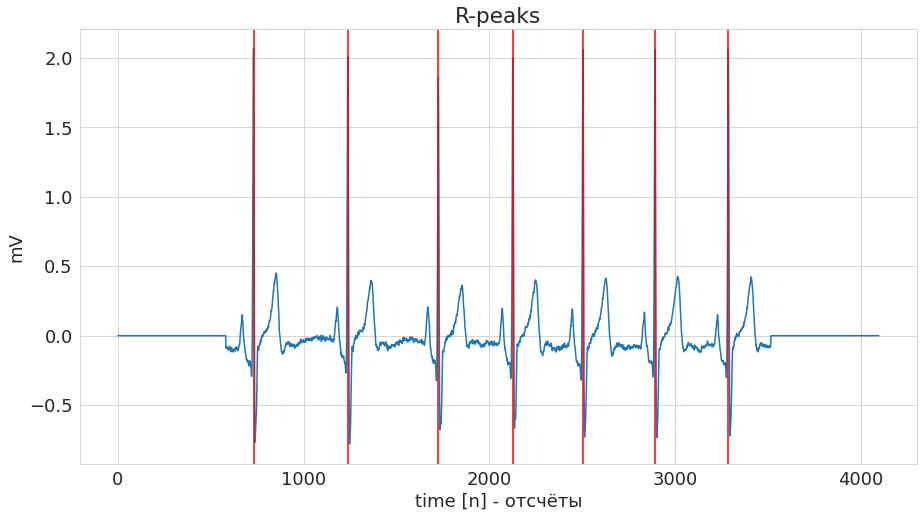

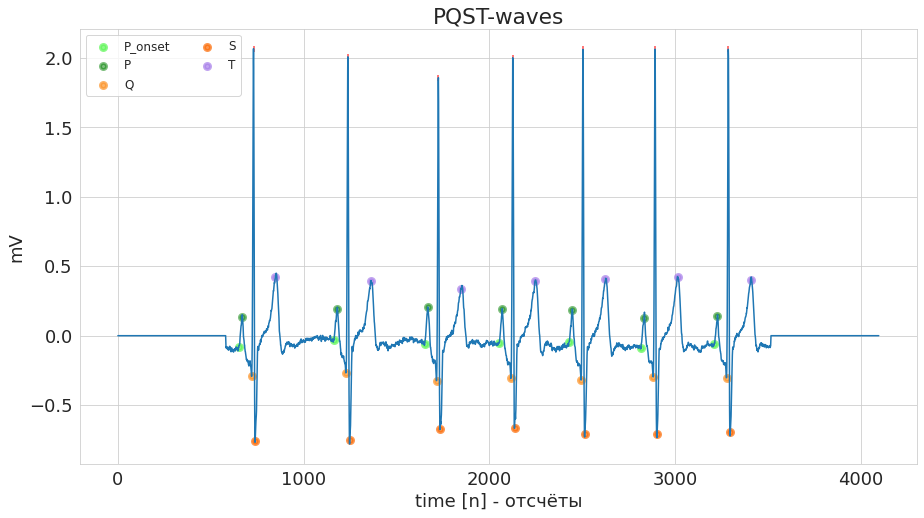

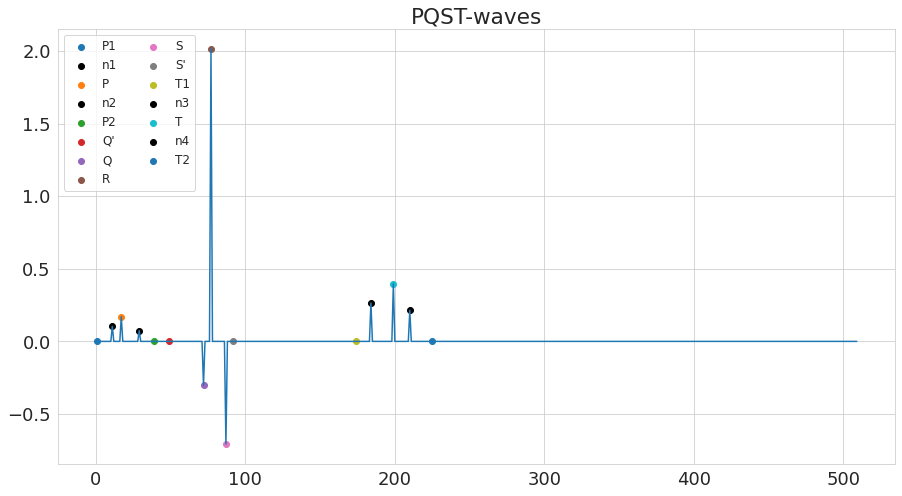

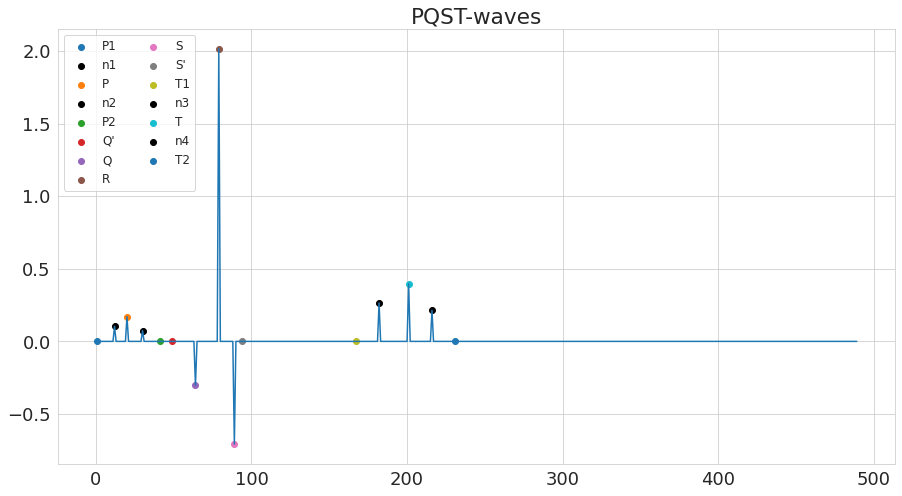

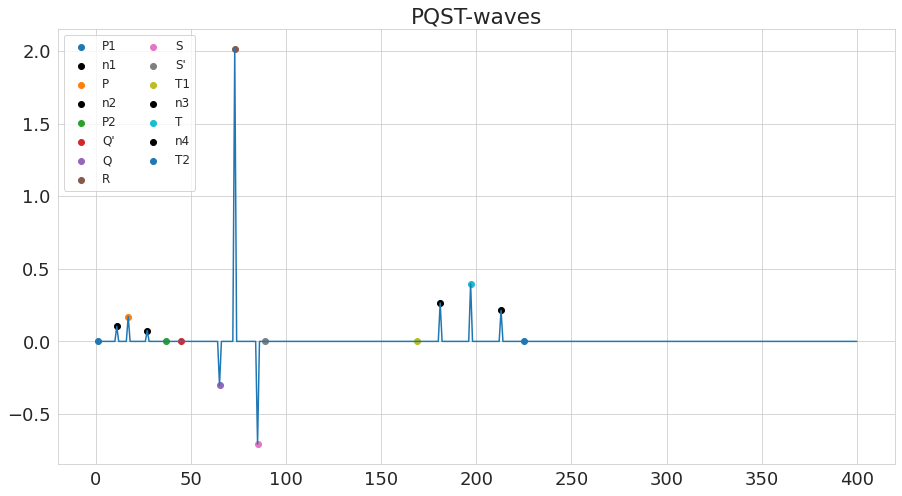

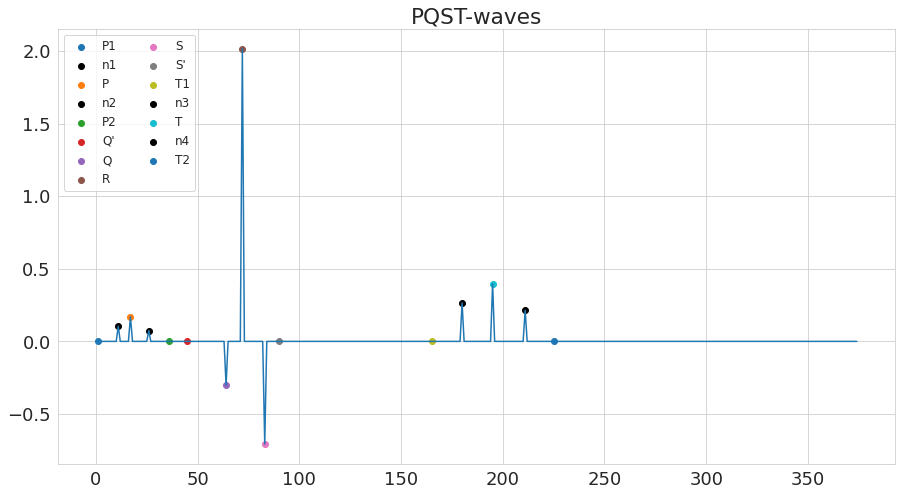

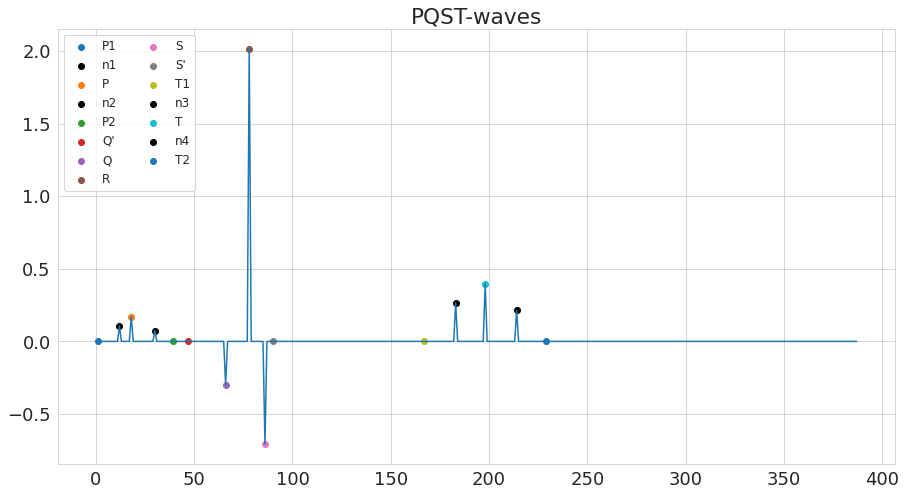

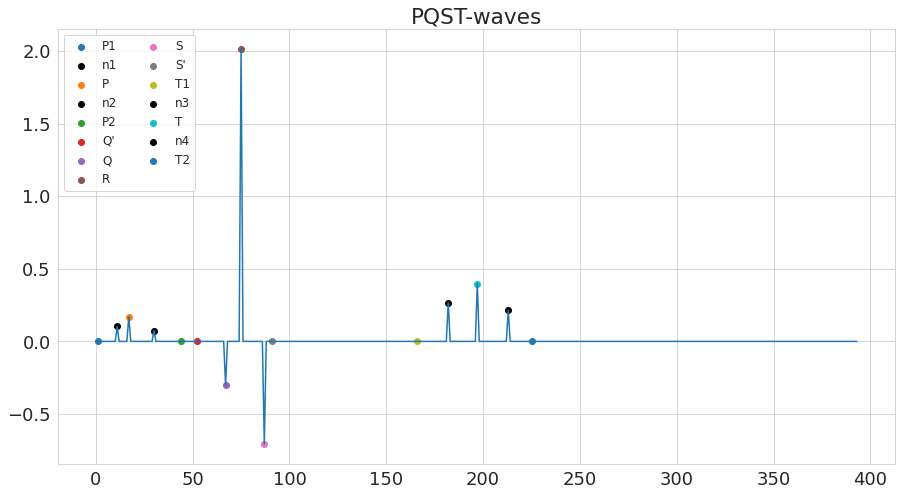

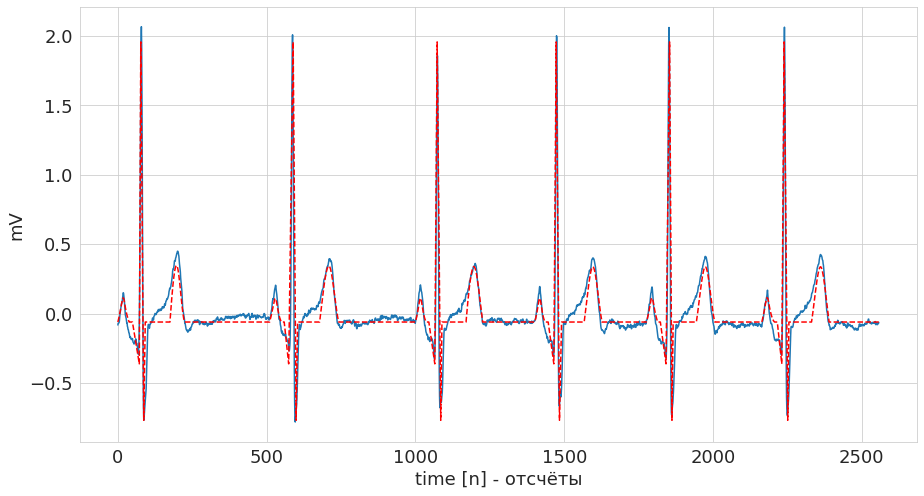

In [ ]:
ideal_ecg_full, ecg_sample_cut = overlay_signals(sig79, show=True, bias=-0.06, method='spline')

mse: 0.020
mae: 0.082


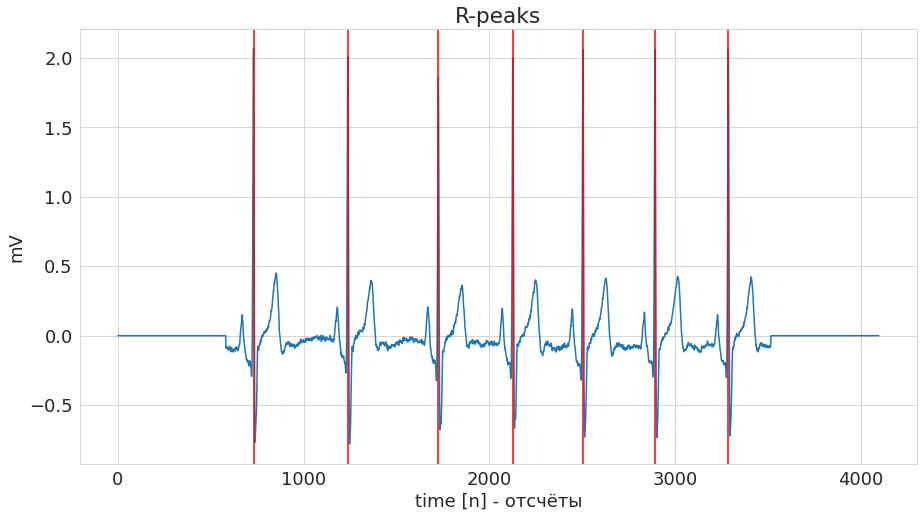

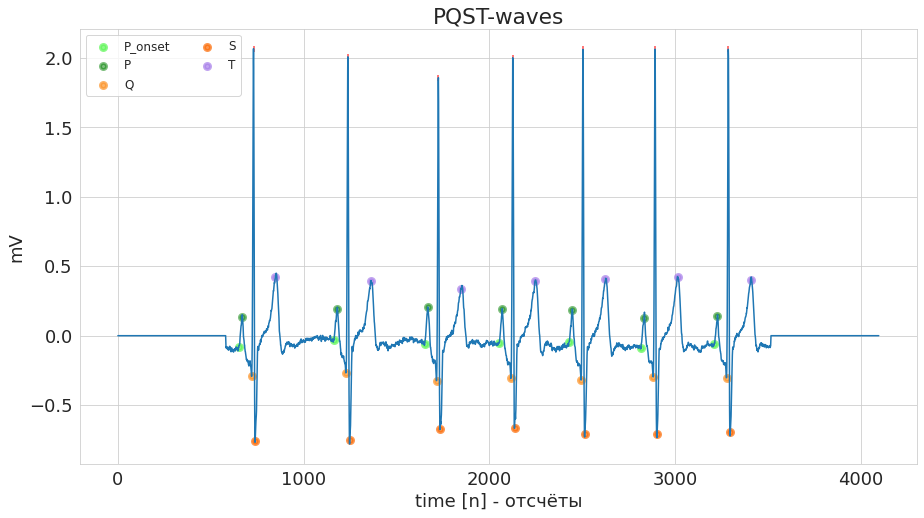

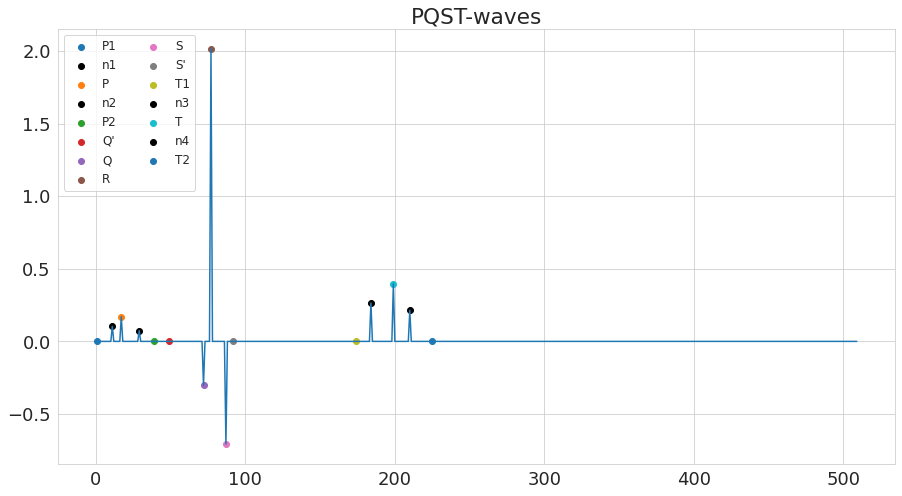

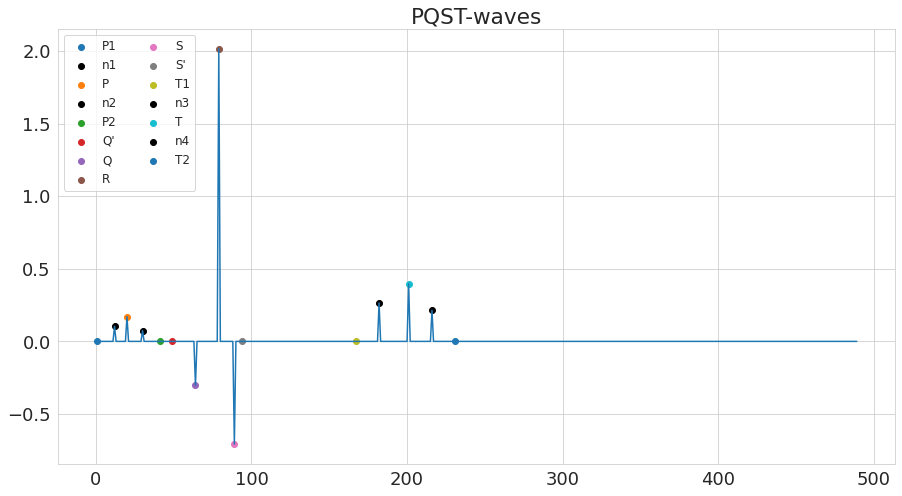

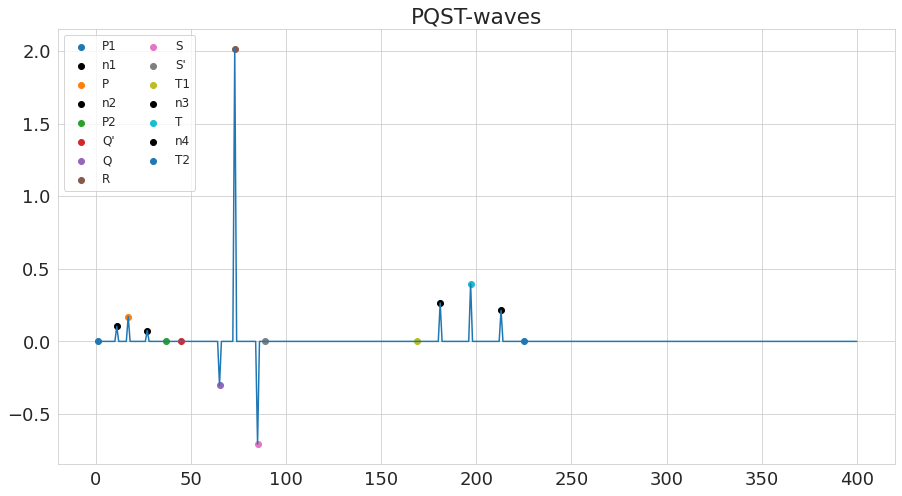

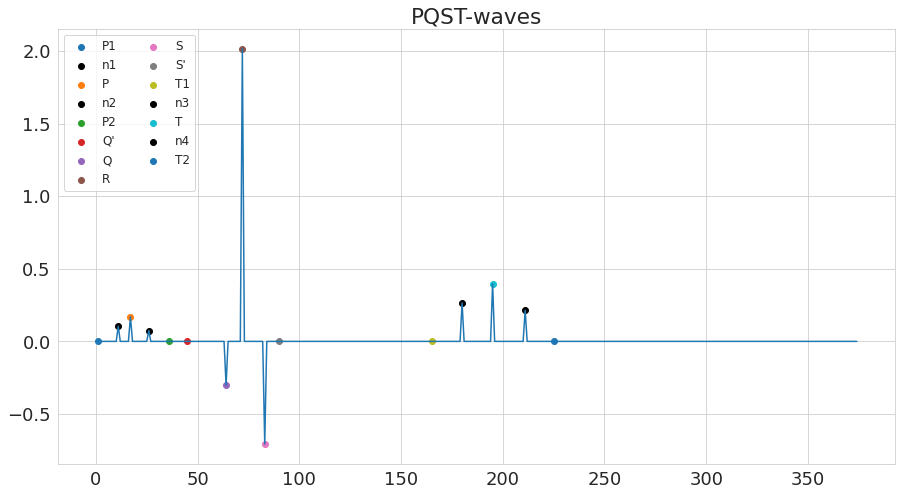

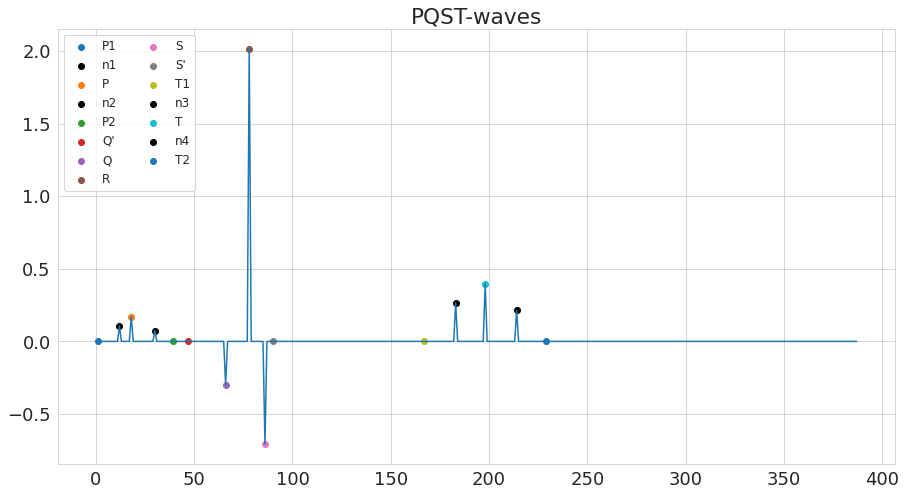

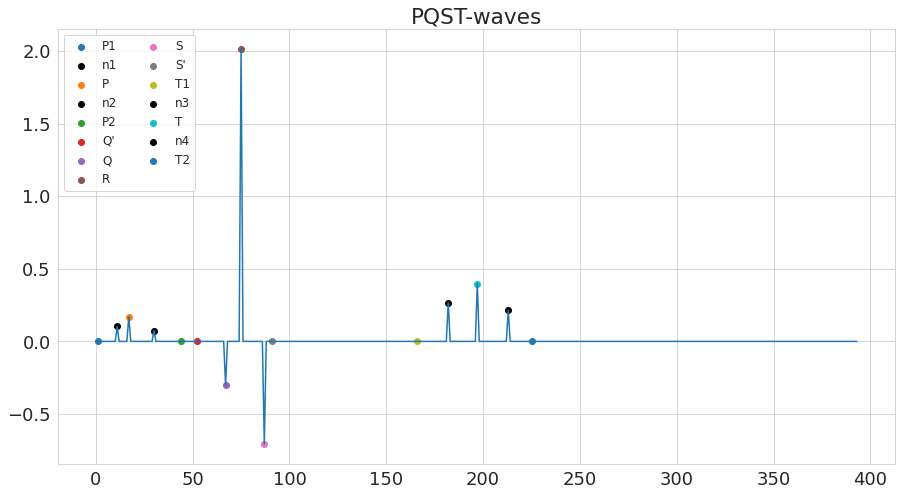

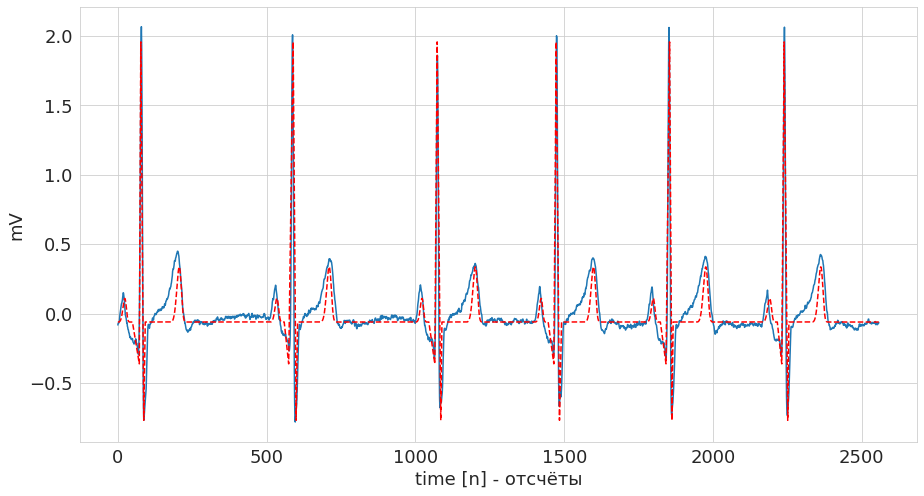

In [ ]:
ideal_ecg_full, ecg_sample_cut = overlay_signals(sig79, show=True, bias=-0.06, method='weib')

mse: 0.020
mae: 0.082


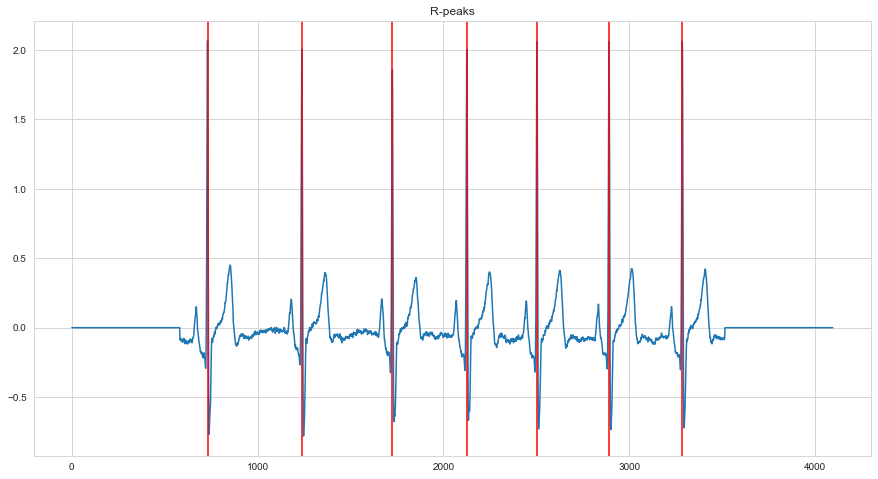

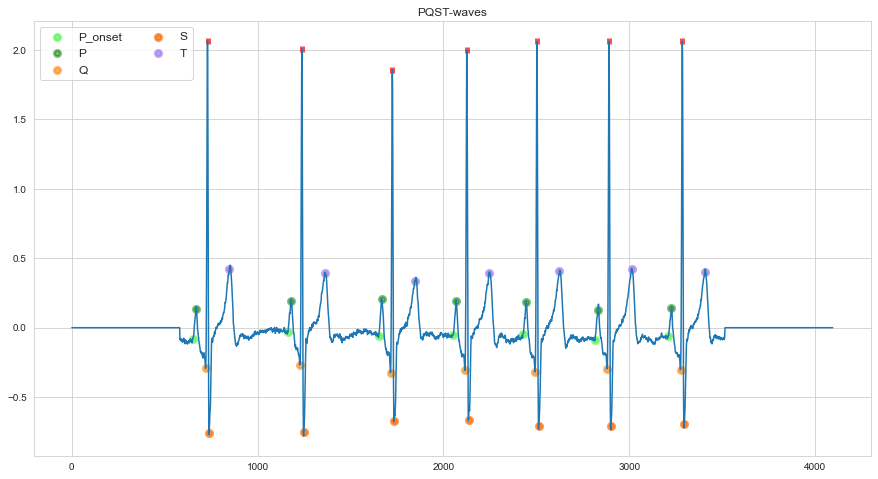

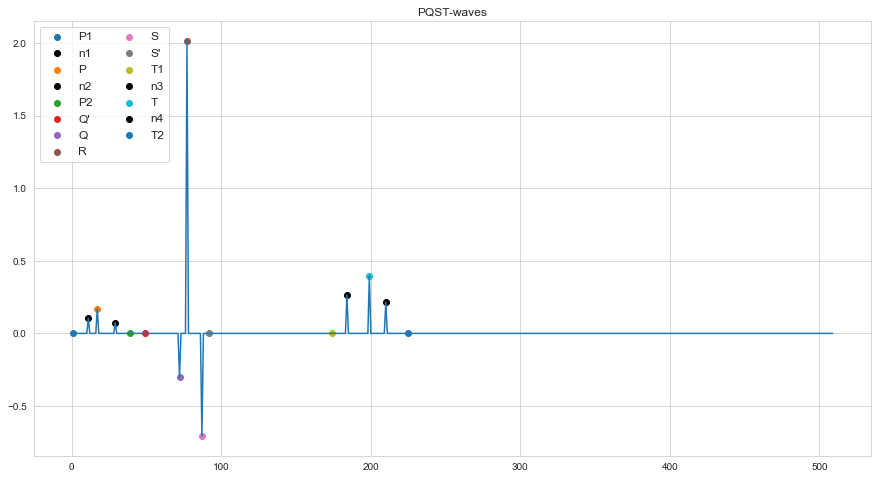

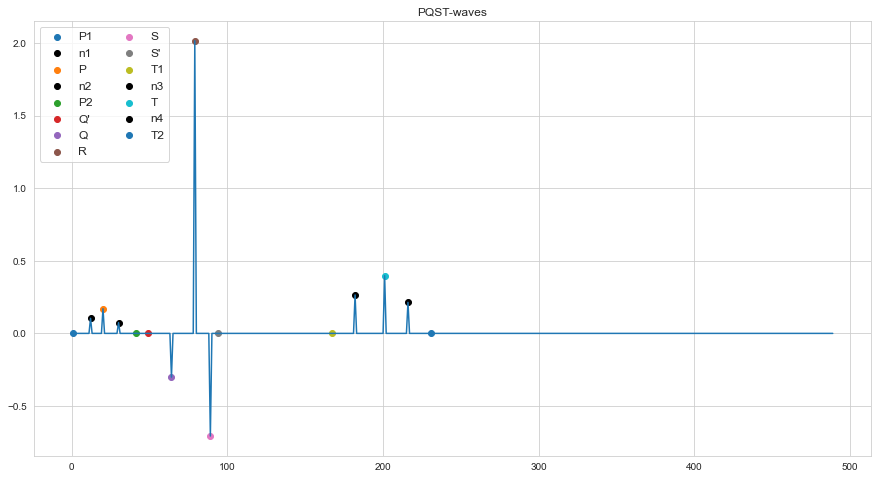

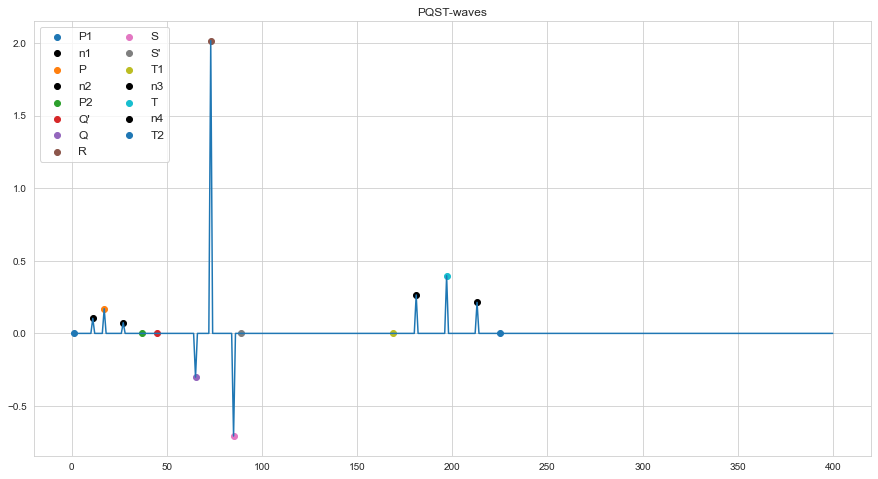

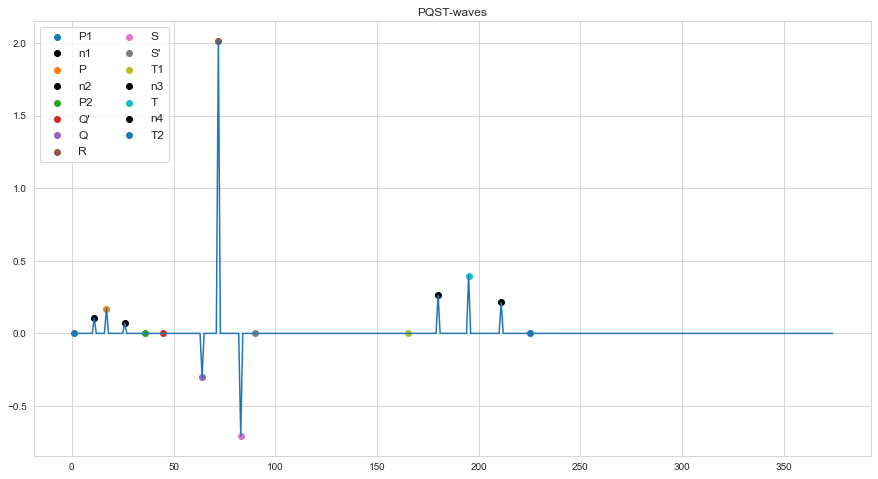

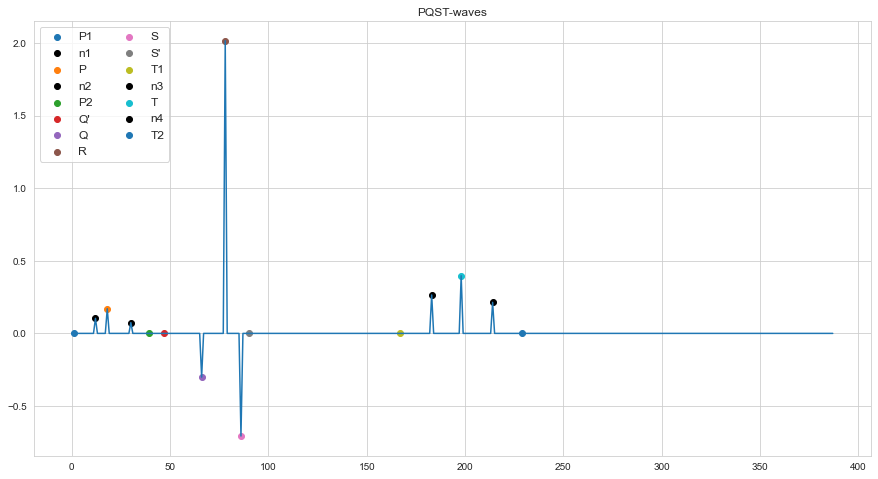

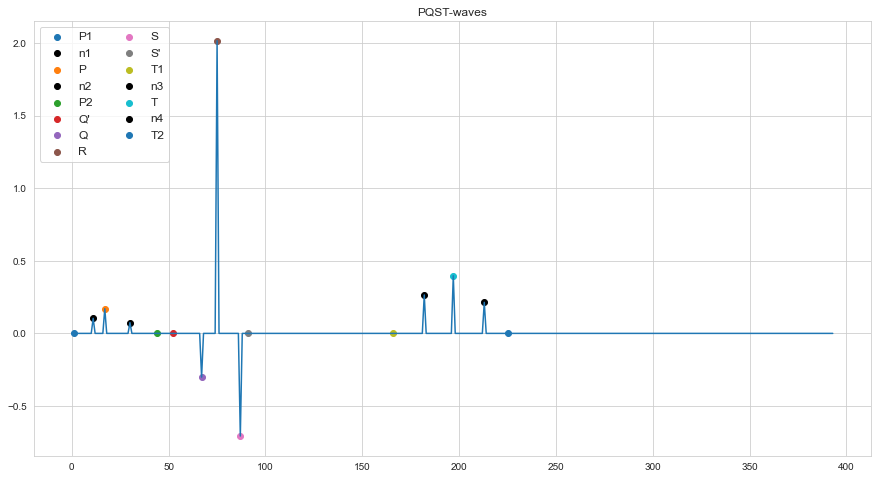

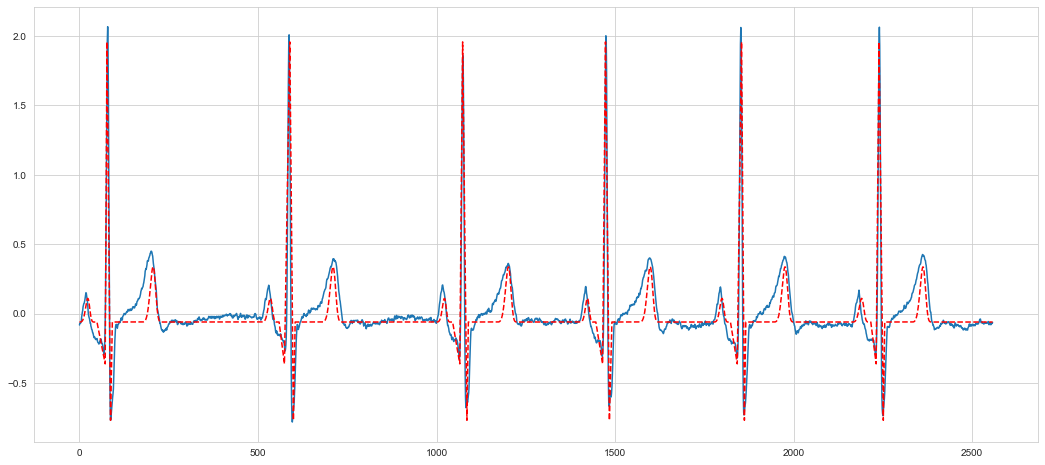

In [ ]:
ideal_ecg_full, ecg_sample_cut = overlay_signals(sig79, show=True, bias=-0.06, method='weib')

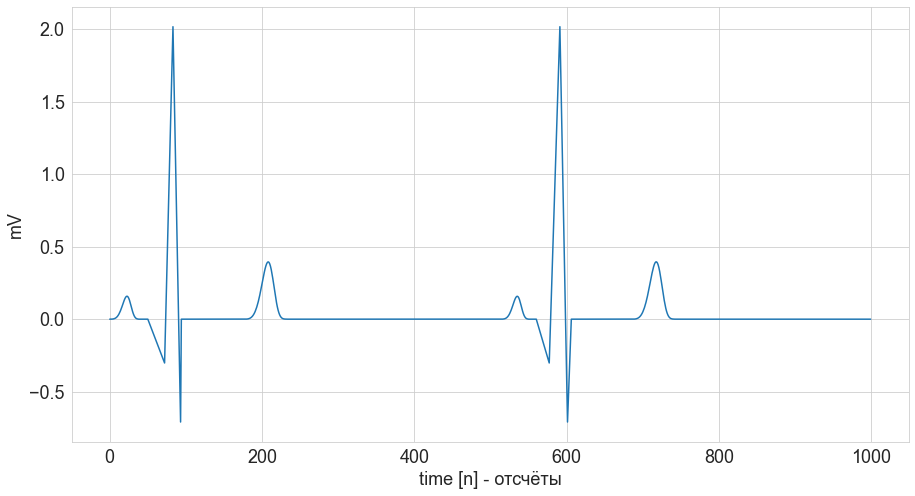

In [ ]:
signal_plot(ideal_ecg_full[:1000])

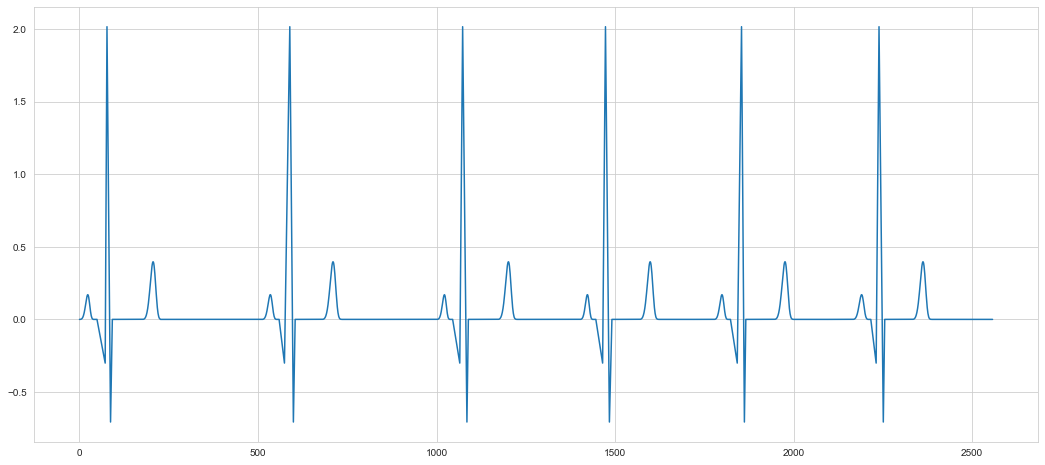

In [ ]:
signal_plot(ideal_ecg_full)